In [1]:
%matplotlib inline

## Imports

In [2]:
from src.image2tokens import extractTokens, extractLines
from src.ocr import Ocr
import json
import sys

# plots
import matplotlib.pyplot as plt

# file cleanup
import numpy as np
import pandas as pd
import re

# opencv
import math
import cv2
from scipy import ndimage

## File handling and pre-processing

Remember, if your pictures are shitty, your analysis is shitty. Take high res pictures. ALWAYS align them orthogonally. Try to avoid vertical or horizontal tilt. Camera perfect 90deg above picture, use flash to avoid your own shadow on the picture - but be sure that the flash doesnt overexpose the text. Check that you are cropping the things you need. Key is to be consistent with how you take your photos - the more consistent you are, the less you have to pre-process (crop,rotate,etc).

True

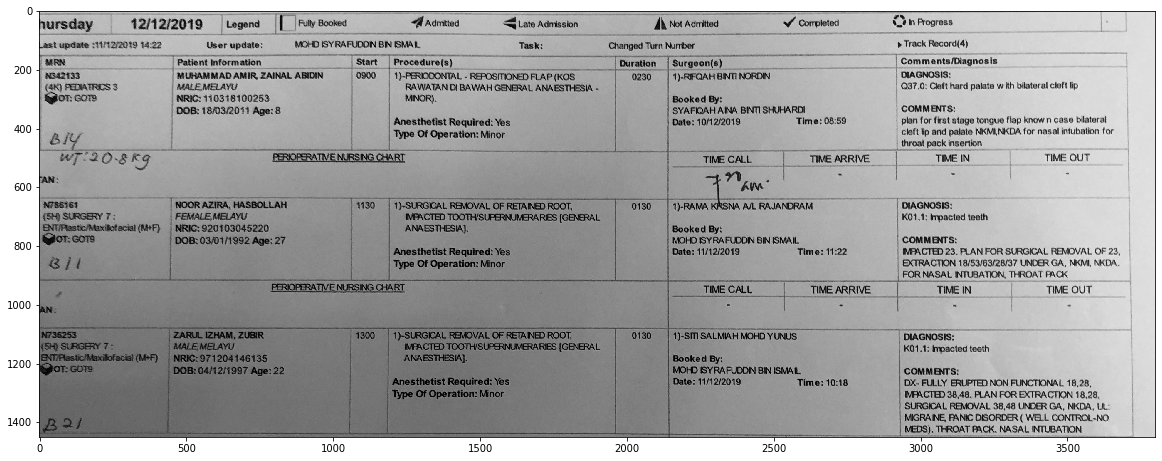

In [3]:
img = cv2.imread('sample/input/02.jpg') # put path to image
crop = img[700:2150, 100:3900] # cropping [ymin:ymax, xmin:xmax]
gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY) # make RGB img gray

f = plt.figure(figsize=(20,8)) # define figure size (x,y)
ax = f.add_subplot(111) 
ax.imshow(gray, cmap='gray', vmin = 0, vmax = 255) # plot in gray

cv2.imwrite('sample/output/2c.jpg', gray) # save processed image to path of this notebook

# edges = cv2.Canny(gray,50,100) # find edges between given threshold; here 50,100

In case you fcked up the rotation or tilt, this is a some code to solve it.

In [ ]:
# Rotate image 
img_before = cv2.imread('sample/input/02.jpg')

# cv2.imshow("Before", img_before)
img_gray = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)
img_edges = cv2.Canny(img_gray, 100, 100, apertureSize=3)
lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)
angles = []

for x1, y1, x2, y2 in lines[0]:
    cv2.line(img_before, (x1, y1), (x2, y2), (255, 0, 0), 3)
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
    angles.append(angle)

median_angle = np.median(angles)
img_rotated = ndimage.rotate(img_before, median_angle)

f = plt.figure(figsize=(20,8)) 
ax = f.add_subplot(111)
ax.imshow(img_rotated)

print ("Angle is {}".format(median_angle))
cv2.imwrite('1r.jpg', img_rotated)

# # vertical tilt
# rows, cols, ch = img.shape    
# pts1 = np.float32(
#     [[cols*.25, rows*.95],
#      [cols*.90, rows*.95],
#      [cols*.10, 0],
#      [cols,     0]]
# )
# pts2 = np.float32(
#     [[cols*0.1, rows],
#      [cols,     rows],
#      [0,        0],
#      [cols,     0]]
# )    
# M = cv2.getPerspectiveTransform(pts1,pts2)
# dst = cv2.warpPerspective(img, M, (cols, rows))
# cv2.imwrite('2c.jpg', dst)

## Functions

These functions shorten the code and makes peoples lives easier.

In [4]:
def changeFileExtension(path,newExtension):
    res = ''.join(path.split(".")[:-1])+'.'+newExtension
    print(res)
    return res

The `main` function takes the input image, uses Google Vision to extract words as `tokens` and returns them in a JSON type encoding (which is just what words, the bounding boxes and its coordinates according to the picture. Then it compiles the tokens from left to right according to the x-coordinates as `lines`. These are put in ze DataFrame.

In [5]:
def main(imagePath):
    # Generate the Optical Character Recognition (OCR) class
    ocr = Ocr()

    # Apply OCR on the image. Creates JSON with the text and the (x,y) coordinates of each word
    ocr.processFile(imagePath,'./')

    # Reads JSON and deletes it
    jsonFile = changeFileExtension(imagePath.split("/")[-1],"json")
    with open(jsonFile,'r') as f:
        image = json.load(f)

    # Extract tokens (Each word, its width, height and its coordinates)
    tokens = extractTokens(image)

    # Sort the tokens into lines
    lines = extractLines(tokens)

    # Put lines in a dataframe
    df = pd.DataFrame(lines)

    return df

Decided to separate the actual dataframe and the cleaned up one. Ideally you just want to have 1 function `main` to extract and clean up according to MRN, procedures and diagnosis. But in case you screw up the image or for some reason you dont get the right things, you can compare them first to the image before you clean it up. This `clean` function searches for specific patterns in e.g. MRN : 1 alphabet N and 6 numerical numbers, procedures start with `1)-` and diagnosis which ends with `.0:` or `.00:`. 

In [6]:
def clean(df):
    # this function looks for e.g. MRN N123456   | .0: or .00: | 1)- to clean up the clutter
    f = lambda x: x.str.contains('([A-Z]{1}\d{6})|[.]\d{1,2}[:]|[1]+[)]+[-]', na=False, case=False) # searches
    df_ = df[df.apply(f).any(axis=1)]
    df__ = pd.concat([df.iloc[[0]],df_]) # appends the 1st line containing the date of the form
    return df__

## Extract words from image

Once the functions are defined, you can define your `imagePath` and return the dataframe as a variable `df` or `df2`, etc. But before we do that, we have to check that our credentials are authenticated since we are using Google Vision API.

In the `main` file, we called `ocr.py` and within that file it calls `googleVisionApi.py` and within that we set our `GOOGLE_APPLICATION_CREDENTIALS`. Go to `googleVisionApi.py` and update your '/path/to/credentials.json'. Run the code below and see if it matches. If yes, we can start extraction.

In [7]:
import os

print('Credentials from environ: {}'.format(os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')))

Credentials from environ: /Users/hud/Documents/img2txt/src/credential.json


In [8]:
imagePath = 'sample/output/1c.jpg'
# imagePath = sys.argv[1]
print('RUNNING ON ' + imagePath)
df=main(imagePath)

imagePath = 'sample/output/2c.jpg'
# imagePath = sys.argv[1]
print('RUNNING ON ' + imagePath)
df2=main(imagePath)

RUNNING ON sample/output/1c.jpg
1c.json
RUNNING ON sample/output/2c.jpg
2c.json


Good idea to double check your dataframes with the image 

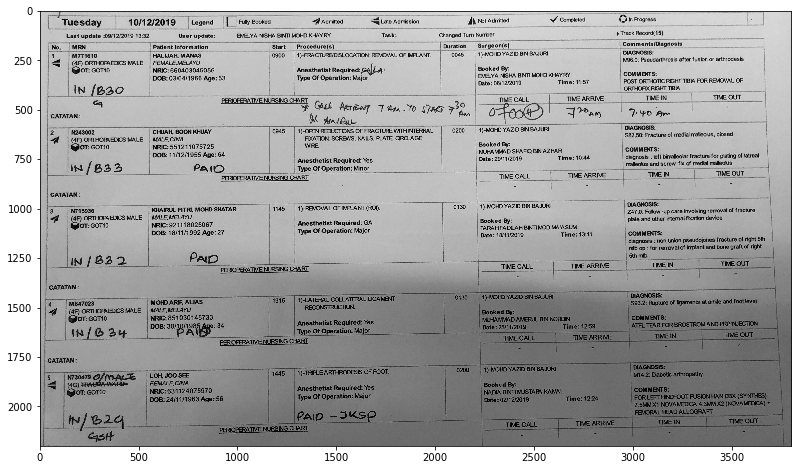

In [11]:
img = cv2.imread('sample/output/1c.jpg')
f = plt.figure(figsize=(20,8)) 
ax = f.add_subplot(111)
ax.imshow(img, cmap='gray',vmin=0,vmax=255)

In [12]:
df

,0,1,2,3,4,5,6,7,8,9
0,Tuesday,10/12/2019,Legend,Fully Booked,Admitted,Late Admission,Not Admitted,✓,Completed,in Progress
1,Last update :09/12/2019 13:32,User update:,EMELYA NISHA BINTI MOHD KHAYRY,Task:,Changed Turn Number,Track Record(15),None,None,None,None
2,No.,MRN,Patient Information,Start,Procedure(s),Duration,Surgeon(s),Comments/Diagnosis,None,None
3,M771610,"HALIJAH, MANAS",0900,1)-FRACTURE/DISLOCATION: REMOVAL OF IMPLANT.,0045,1)-MOHD YAZD BIN BAJURI,DIAGNOSIS:,None,None,None
4,(4F) ORTHOPAEDICS MALE,"FEMALE, MELAYU",M96.0: Pseudarthrosis after fusion or arthrodesis,None,None,None,None,None,None,None
5,OT: GOT10,NRIC: 660403045056,Anesthetist Required: GALLA,Booked By:,None,None,None,None,None,None
6,DOB: 03/04/1966 Age:53,Type Of Operation: Major,EMEYA NISHA BINTI MOHD KHAYRY,COMMENTS:,None,None,None,None,None,None
7,Date:06/12/2019,Time: 11:57,POST ORTHOTIC RIGHT TIBIA FOR REMOVAL OF,None,None,None,None,None,None,None
8,IN,/B30,ORTHOFK RIGHT TBA,None,None,None,None,None,None,None
9,PERIOPERATIVE NURSING CHART,TIME CALL,TIME ARRIVE,TIME IN,TIME OUT,None,None,None,None,None


In [13]:
df_ = clean(df)
df_

/Users/hud/.virtualenvs/test/lib/python3.8/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,0,1,2,3,4,5,6,7,8,9
0,Tuesday,10/12/2019,Legend,Fully Booked,Admitted,Late Admission,Not Admitted,✓,Completed,in Progress
3,M771610,"HALIJAH, MANAS",0900,1)-FRACTURE/DISLOCATION: REMOVAL OF IMPLANT.,0045,1)-MOHD YAZD BIN BAJURI,DIAGNOSIS:,None,None,None
4,(4F) ORTHOPAEDICS MALE,"FEMALE, MELAYU",M96.0: Pseudarthrosis after fusion or arthrodesis,None,None,None,None,None,None,None
12,2,N243002,"CHUAH, BOON KHUAY",0945,| 1)-OPEN REDUCTIONS OF FRACTURE WITH INTERNAL 1,0200,1)-MOHD YAZD BIN BAJURI,DIAGNOSIS:,None,None
13,(4F) ORTHOPAEDICS MALE,"FXATION: SCREWS, NAILS, PLATE, CIRCLAGE","S82.50: Fracture of medial malleolus, closed",None,None,None,None,None,None,None
21,"KHAIRUL FITRI, MOHD SHATAR",1145,1)-REMOVAL OF MPLANT (ROI).,0130,1)-MOHD YAZD BIN BAJURI,DIAGNOSIS:,None,None,None,None
22,N715936,247.0: Follow-up care involving removal of fra...,None,None,None,None,None,None,None,None
32,1315,1)-LATERAL COLLATERAL LIGAMENT,0130,| 1)-MOHD YAZD BIN BAJURI,DIAGNOSIS:,level,None,None,None,None
33,M847023,"MOHD ARIF, ALIAS",S93.2: Rupture of ligaments at ankle and foot,None,None,None,None,None,None,None
40,1445,1)-TRIPLE ARTHRODESIS OF FOOT.,0200,1)-MOHD YAZD BIN BAJURI,M14.2: Diabetic arthropathy,None,None,None,None,None


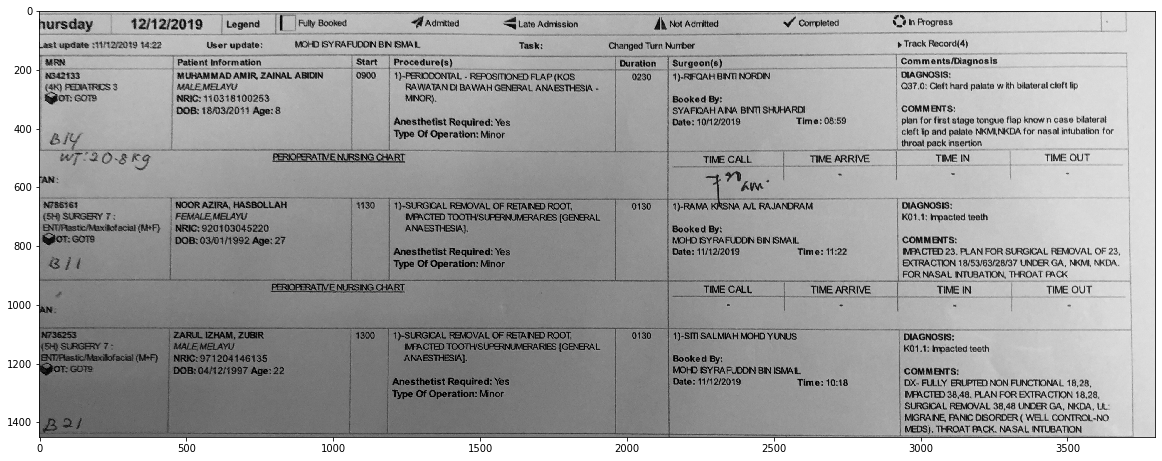

In [14]:
img = cv2.imread('sample/output/2c.jpg')
f = plt.figure(figsize=(20,8)) 
ax = f.add_subplot(111)
ax.imshow(img, cmap='gray',vmin=0,vmax=255)

In [15]:
df2

,0,1,2,3,4,5,6,7,8,9
0,hursday,12/12/2019,Legend,Full Booked,Admitted,Late Admission,Not Admitted,✓,Completed,In Progress
1,Last update : 11/12/2019 14:22,User update:,MOHD ISYRAFUDDN BIN ISMAL,Task:,Changed Turn Number,Track Record(4),None,None,None,None
2,NRN,Patient Information,Start,Procedure(s),Duration,Surgeon(s),Comments/Diagnosis,None,None,None
3,N342133,"MUHAMMAD AMIR, ZAINAL ABIDIN",0900,1)-PERIODONTAL - REPOSITIONED FLAP (KOS,0230,1)-RFQAH BINTI NORDIN,DIAGNOSIS:,None,None,None
4,(4K) PEDIATRICS 3,MALE.MELAYU,RAWATAN DI BAWAH GENERAL ANAESTHESIA -,Q37.0: Cleft hard palate with bilateral cleft lip,None,None,None,None,None,None
5,OT: GOT,NRIC: 110318100253,MINOR).,Booked By:,None,None,None,None,None,None
6,DOB: 18/03/2011 Age: 8,SYAFIQAHANA BINTI SHUHARDI,COMMENTS:,None,None,None,None,None,None,None
7,Anesthetist Required: Yes,Date: 10/12/2019,Time: 08:59,plan for first stage tongue flap known case bi...,None,None,None,None,None,None
8,Type Of Operation: Minor,cleft lip and palate NKMINKDA for nasal intuba...,None,None,None,None,None,None,None,None
9,B19:20.8kg,throat pack insertion,None,None,None,None,None,None,None,None


In [16]:
df2_ = clean(df2)
df2_

,0,1,2,3,4,5,6,7,8,9
0,hursday,12/12/2019,Legend,Full Booked,Admitted,Late Admission,Not Admitted,✓,Completed,In Progress
3,N342133,"MUHAMMAD AMIR, ZAINAL ABIDIN",0900,1)-PERIODONTAL - REPOSITIONED FLAP (KOS,0230,1)-RFQAH BINTI NORDIN,DIAGNOSIS:,None,None,None
4,(4K) PEDIATRICS 3,MALE.MELAYU,RAWATAN DI BAWAH GENERAL ANAESTHESIA -,Q37.0: Cleft hard palate with bilateral cleft lip,None,None,None,None,None,None
12,N786161,"NOOR AZIRA, HASBOLLAH",1130,"1)-SURGICAL REMOVAL OF RETAINED ROOT,",01301)-RAMA KRSNA A/L RAJANDRAM,DIAGNOSIS:,None,None,None,None
13,(5H) SURGERY 7:,FEMALE MELAYU,MPACTED TOOTH/SUPERNUMERARES (GENERAL,K01.1: Impacted teeth,None,None,None,None,None,None
21,N736253,"ZARUL IZHAM, ZUBIR","13001)-SURGICAL REMOVAL OF RETAINED ROOT,",0130,1)-SITI SALMIAH MOHD YUNUS,DIAGNOSIS:,None,None,None,None
22,(5H) SURGERY 7:,MALE MELAYU,IMPACTED TOOTH/SUPERNUMERARES (GENERAL,K01.1: Impacted teeth,None,None,None,None,None,None


## fin